# Metaphor - Regressions

### Load Libraries

In [1]:
import os.path as op

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import (Poisson, Logit)

import re

# Load Data

We end up with 455 cancer-related projects in total

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
labeled = pd.read_csv(op.join(DATA_PROCESSED, 'labeled_projects.csv'))
all_projects = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects_full.csv'))

In [4]:
len(set(labeled['project_id'])), len(all_projects)

(455, 455)

Create features related to metaphor usage in each project.

**\*_metaphor**: A count of how many (battle/journey)-related keywords were found in the project body text.

**\*_uniques**: A count of how many unique (battle/journey) keywords were found in the project body text.

**\*_salience**: A ratio of (battle/journey)-related keywords to total words in the project body text.

**\*_productivity**: A ratio of unique (battle/journey) keywords to total number of (battle/journey)-related keywords found in the project body text.

**dominant_\***: Boolean value if the dominant metaphor type used in the project body text was either battle, journey, equal amount of both, or neither.

In [5]:
all_projects['battle_metaphor'] = all_projects['id'].apply(
    lambda ix: len(labeled.loc[(labeled['project_id'] == ix) & (labeled['type'] == 'battle')])
)
all_projects['journey_metaphor'] = all_projects['id'].apply(
    lambda ix: len(labeled.loc[(labeled['project_id'] == ix) & (labeled['type'] == 'journey')])
)
all_projects['battle_uniques'] = all_projects['id'].apply(
    lambda ix: len(set(labeled.loc[(labeled['project_id'] == ix) & (labeled['type'] == 'battle'), 'keyword']))
)
all_projects['journey_uniques'] = all_projects['id'].apply(
    lambda ix: len(set(labeled.loc[(labeled['project_id'] == ix) & (labeled['type'] == 'journey'), 'keyword']))
)

In [6]:
all_projects['battle_salience'] = all_projects['battle_metaphor'] / all_projects['text_length_words']
all_projects['journey_salience'] = all_projects['journey_metaphor'] / all_projects['text_length_words']

all_projects['battle_productivity'] = all_projects['battle_uniques'] / all_projects['battle_metaphor']
all_projects['journey_productivity'] = all_projects['journey_uniques'] / all_projects['journey_metaphor']

all_projects = all_projects.fillna(0)

all_projects['dominant_battle'] = (all_projects['battle_salience'] > all_projects['journey_salience']).astype(int)
all_projects['dominant_journey'] = (all_projects['battle_salience'] < all_projects['journey_salience']).astype(int)
all_projects['dominant_both'] = ((all_projects['battle_salience'] == all_projects['journey_salience']) & (all_projects['battle_salience'] > 0)).astype(int)
all_projects['dominant_neither'] = ((all_projects['battle_salience'] == all_projects['journey_salience']) & (all_projects['battle_salience'] == 0)).astype(int)

Keep only projects labeled as successful or failed. Remove outlier projects with more than 500 backers (removes less than 10).

Convert duration into a decimal of days. Boolean feature if the project lasted around $30 \pm 2$ days.

Dataset reduced to just over 400 projects.

In [7]:
all_projects = all_projects[all_projects['status'].isin(['successful', 'failed'])].copy()

all_projects = all_projects.loc[all_projects['backers'] < 500].copy()

all_projects['status'] = all_projects['status'].apply(lambda r: 1 if r == 'successful' else 0)

all_projects['duration_float'] = all_projects['duration'] / (60 * 60 * 24)
all_projects['duration_30days'] = all_projects['duration_float'].apply(lambda d: 1 if np.abs(d - 30) < 2 else 0)

In [8]:
len(all_projects)

402

# Regressions

### Dependent Variables to Focus on

 - Pledged to Goal
  - Focused mainly around 0 and 1-2, with some outliers after 2
 - Mean Donation
 - Status (success or failure)
  - Logistic Regression
 - Backers
  - Long tailed Poisson, remove the outliers

In [9]:
independent_var_keys = np.array(
    ['battle_salience', 'journey_salience', 'journey_metaphor', 'battle_metaphor', 'journey_productivity', 'battle_productivity', 
    'dominant_battle', 'dominant_journey', 'dominant_neither', 'dominant_both',
    'duration_30days', 'day_of_week', 'month', 'year',
    'from_US', 'from_Town', 
    'blurb_length_words', 'text_length_sentences', 'text_length_words', 'text_length_chars', 
    'staff_pick'])

### Regress over the project status (success/fail)

In [10]:
status_model = Logit(all_projects['status'], all_projects[independent_var_keys].astype(float)).fit()

Optimization terminated successfully.
         Current function value: 0.586655
         Iterations 8


In [11]:
status_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                  402
Model:                          Logit   Df Residuals:                      381
Method:                           MLE   Df Model:                           20
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:                  0.1536
Time:                        19:20:31   Log-Likelihood:                -235.84
converged:                       True   LL-Null:                       -278.64
                                        LLR p-value:                 4.296e-10
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
battle_salience        -111.7327     75.795     -1.474      0.140    -260.288      36.822
journey_salience        -86.5065     78.848     -1.097      0.273    -241.046      68.033
journey_metaphor          0.9568      0.546      1.751      0.080      -0.114       2.028
battle_metaphor           0.2443      0.238      1.027      0.304      -0.222       0.710
journey_productivity      1.3905      1.152      1.207      0.228      -0.868       3.649
battle_productivity       0.9355      1.398      0.669      0.503      -1.805       3.676
dominant_battle         566.1393    131.696      4.299      0.000     308.020     824.259
dominant_journey        564.9081    131.784      4.287      0.000     306.616     823.200
dominant_neither        566.5100    131.882      4.296      0.000     308.026     824.994
dominant_both           566.2513    131.649      4.301      0.000     308.224     824.279
duration_30days           0.2101      0.228      0.920      0.358      -0.238       0.658
day_of_week               0.1305      0.061      2.129      0.033       0.010       0.251
month                    -0.0559      0.036     -1.563      0.118      -0.126       0.014
year                     -0.2816      0.065     -4.306      0.000      -0.410      -0.153
from_US                   0.0415      0.321      0.130      0.897      -0.587       0.670
from_Town                -0.2629      0.538     -0.488      0.625      -1.318       0.792
blurb_length_words        0.0224      0.027      0.819      0.413      -0.031       0.076
text_length_sentences     0.0086      0.016      0.536      0.592      -0.023       0.040
text_length_words        -0.0068      0.004     -1.776      0.076      -0.014       0.001
text_length_chars         0.0012      0.001      1.888      0.059   -4.62e-05       0.002
staff_pick                2.3672      0.807      2.933      0.003       0.785       3.949
=========================================================================================
"""

### Regress over the number of backers

In [12]:
backers_model = Poisson(all_projects['backers'].astype(float), 
                              all_projects[independent_var_keys].astype(float)).fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 34.63711476848275
            Iterations: 84
            Function evaluations: 137
            Gradient evaluations: 84


/Users/alex/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:984: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))


In [13]:
backers_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                backers   No. Observations:                  402
Model:                        Poisson   Df Residuals:                      381
Method:                           MLE   Df Model:                           20
Date:                Tue, 06 Nov 2018   Pseudo R-squ.:                  0.2530
Time:                        19:20:31   Log-Likelihood:                -13924.
converged:                       True   LL-Null:                       -18640.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
battle_salience         -66.4613      5.136    -12.940      0.000     -76.528     -56.395
journey_salience         -7.9843      4.369     -1.828      0.068     -16.547       0.578
journey_metaphor          0.1037      0.017      6.023      0.000       0.070       0.137
battle_metaphor           0.1333      0.012     11.466      0.000       0.110       0.156
journey_productivity      0.3706      0.047      7.923      0.000       0.279       0.462
battle_productivity       0.4284      0.057      7.536      0.000       0.317       0.540
dominant_battle         202.2047      7.943     25.458      0.000     186.637     217.772
dominant_journey        202.2090      7.953     25.425      0.000     186.621     217.797
dominant_neither        202.5344      7.960     25.445      0.000     186.934     218.135
dominant_both           201.9722      7.934     25.457      0.000     186.422     217.522
duration_30days           0.0981      0.015      6.615      0.000       0.069       0.127
day_of_week               0.0729      0.004     19.097      0.000       0.065       0.080
month                    -0.0049      0.002     -2.142      0.032      -0.009      -0.000
year                     -0.0989      0.004    -25.063      0.000      -0.107      -0.091
from_US                   0.1036      0.021      4.848      0.000       0.062       0.145
from_Town                -0.1571      0.033     -4.765      0.000      -0.222      -0.092
blurb_length_words       -0.0044      0.002     -2.384      0.017      -0.008      -0.001
text_length_sentences     0.0175      0.001     20.569      0.000       0.016       0.019
text_length_words        -0.0032      0.000    -20.667      0.000      -0.003      -0.003
text_length_chars         0.0005   2.54e-05     20.192      0.000       0.000       0.001
staff_pick                1.3618      0.020     67.651      0.000       1.322       1.401
=========================================================================================
"""

# Correlation heatmap

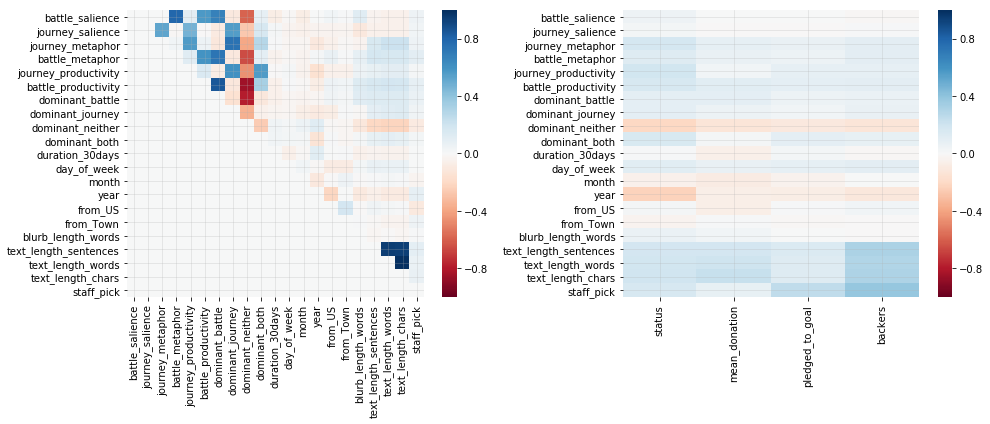

In [14]:
plt.subplots(1, 2, figsize=(14,6))
plt.subplot(121)
g=sns.heatmap(np.triu(all_projects[independent_var_keys].corr(), k=1), center=0, cmap='RdBu', vmin=-1, vmax=1)
g.set_xticklabels(independent_var_keys, rotation=90)
g.set_yticklabels(independent_var_keys, rotation=0);
plt.grid(alpha=0.3)

plt.subplot(122)
d = ['status', 'mean_donation', 'pledged_to_goal', 'backers']

k2 = np.concatenate((independent_var_keys, d))
corr = all_projects[k2].corr()
g=sns.heatmap(corr.loc[~corr.index.isin(d), corr.index.isin(d)], center=0, cmap='RdBu', vmin=-1, vmax=1)
plt.tight_layout()
plt.grid(alpha=0.3)

# Dominant Metaphor effect on Status

In [15]:
def merge(row):
    
    if row['dominant_both'] == 1:
        return 'Both'
    elif row['dominant_neither'] == 1:
        return 'Neither'
    elif row['dominant_battle'] == 1:
        return 'Battle'
    elif row['dominant_journey'] == 1:
        return 'Journey'
    
    return ''

all_projects['dominant'] = all_projects.apply(merge, axis=1)

In [16]:
dominant_anova = smf.ols('status ~ C(dominant)', data=all_projects).fit()

In [17]:
dominant_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 status   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7.996
Date:                Tue, 06 Nov 2018   Prob (F-statistic):           3.46e-05
Time:                        19:20:33   Log-Likelihood:                -280.00
No. Observations:                 402   AIC:                             568.0
Df Residuals:                     398   BIC:                             584.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.5882      0.048     12.174      0.000       0.493       0.683
C(dominant)[T.Both]        0.3403      0.139      2.447      0.015       0.067       0.614
C(dominant)[T.Journey]     0.1041      0.107      0.971      0.332      -0.107       0.315
C(dominant)[T.Neither]    -0.1613      0.057     -2.829      0.005      -0.273      -0.049
==============================================================================
Omnibus:                        0.132   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.936   Jarque-Bera (JB):               55.482
Skew:                           0.044   Prob(JB):                     8.96e-13
Kurtosis:                       1.182   Cond. No.                         7.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""